<a href="https://colab.research.google.com/github/tssorokina/other_files/blob/main/MNIST_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import math
import torch.nn as nn

from tqdm import tqdm
import numpy as np
import datetime


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:

class MnistDataset(Dataset):
  def __init__(self, x, y, conditional=True):
    self.x = torch.from_numpy(x).to(torch.float32)
    self.y = torch.from_numpy(y).long()
    self.conditional = conditional

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    if self.conditional:
        return self.x[idx], self.y[idx]
    else:
        return self.x[idx]

train_dataset = MnistDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = MnistDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Diffuser code

In [ ]:
import torch
import math

class BaseDiffuser:
    def __init__(self, model, diffusion_steps=1000, beta_start=1e-4, beta_end=0.02, device='cpu', scheduler='linear'):
        """
        Base constructor for diffusion operations.

        Args:
            model: Trained model used for noise removal.
            diffusion_steps (int, optional): Total diffusion steps. Defaults to 1000.
            beta_start (float, optional): Beta start value. Defaults to 1e-4.
            beta_end (float, optional): Beta end value. Defaults to 0.02.
            device (str, optional): Either 'cpu' or 'cuda'. Defaults to 'cpu'.
            scheduler (str, optional): Scheduler type. Defaults to 'linear'.
        """
        self.diffusion_steps = diffusion_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = torch.device(device)
        self.model = model.to(self.device)
        self.alpha, self.beta = self.noise_schedule(scheduler)
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma = self.beta.sqrt()

    def __len__(self):
        return self.diffusion_steps

    def noise_schedule(self, scheduler):
        """
        Build a noise scheduler based on the provided scheduler type, total steps, and start/end betas.

        Args:
            scheduler (str): A scheduler type (currently only 'linear' is supported).

        Returns:
            Tensor: Corresponding alphas and betas.
        """
        scale = 1000 / self.diffusion_steps
        if scheduler == 'linear':
            betas = torch.linspace(scale * self.beta_start, scale * self.beta_end, self.diffusion_steps, device=self.device).type(torch.float32)
            alphas = 1.0 - betas
        else:
            raise Exception('Undefined scheduler name')


        return alphas, betas

    def sample_timesteps(self, n):
        """
        Sample list of random timesteps.

        Args:
            n (int): Number of timesteps to generate.

        Returns:
            Tensor: Generated list of random timesteps.
        """
        return torch.randint(low=1, high=self.diffusion_steps, size=(n,), device=self.device)

    def add_noise(self, x_num, t):
        """
        Add Gaussian noise to the input data given a specific timestep value.

        Args:
            x_num (Tensor): Input data tensor.
            t (Tensor): List of timesteps.

        Returns:
            Tensor: A data tensor with injected noise (x_noise_num) and noise itself (x_noise).
        """
        sqrt_alpha_bar = self.alpha_bar[t].sqrt()[:, None]
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bar[t]).sqrt()[:, None]
        noise_num = torch.randn_like(x_num, device=self.device)
        x_noise_num = sqrt_alpha_bar * x_num + sqrt_one_minus_alpha_bar * noise_num
        return x_noise_num, noise_num

    def denoise_step(self, x_t, t, label):
        """
        Sampling or denoising step.

        Args:
            x_t (Tensor): Initial data tensor.
            t (Tensor): List of timesteps.

        Returns:
            Tensor: Denoised tensor.
        """
        alpha_t = self.alpha[t][:, None]
        alpha_bar_t = self.alpha_bar[t][:, None]
        alpha_bar_t1 = self.alpha_bar[t-1][:, None]
        beta_t = self.beta[t][:, None]
        sigma_t = self.sigma[t][:, None]
        random_noise = torch.randn_like(x_t, device=self.device)
        random_noise[t == 0] = 0.0

        noise_pred = self.model(x=x_t, timesteps=t, label=label) ###🥑🥑
        x_0_hat = (x_t - (1 - alpha_bar_t).sqrt() * noise_pred) / alpha_bar_t.sqrt()
        # x_0_hat = x_0_hat.clamp(-1,1)

        x0_coeff = alpha_bar_t1.sqrt() * beta_t / (1 - alpha_bar_t)
        xt_coeff = alpha_t.sqrt() * (1 - alpha_bar_t1) / (1 - alpha_bar_t)

        # what chat gpt is proposing:
        # x0_coeff = alpha_bar_t1.sqrt()
        # xt_coeff = (1 - beta_t).sqrt() / alpha_bar_t.sqrt()

        x_prev = x_0_hat * x0_coeff + x_t * xt_coeff + sigma_t * random_noise

        return x_prev

    def sample(self, sz, label):
        """
        Generate a sample using the diffusion model.

        Args:
            sz (tuple, optional): Size of the generated sample. Defaults to (1, 28, 28).

        Returns:
            Tensor: Generated sample.
        """
        x_t = torch.rand(sz, device=self.device)
        preds = []
        for t in reversed(range(self.diffusion_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=self.device, dtype=torch.long)
            x_t = self.denoise_step(x_t, t_batch, label)
            preds.append(x_t.float().cpu())
        return preds


#### Looking into whether the coefficients sum up tp one or not

Spoiler: they do not and I have no idea why

In [ ]:
t = torch.arange(1,diffuser.diffusion_steps)
alpha_t = diffuser.alpha[t][:, None, None]
alpha_bar_t = diffuser.alpha_bar[t][:, None, None]
alpha_bar_t1 = diffuser.alpha_bar[t-1][:, None, None]
beta_t = diffuser.beta[t][:, None, None]
sigma_t = diffuser.sigma[t][:, None, None]

x0_coeff = (alpha_bar_t1.sqrt() * beta_t / (1 - alpha_bar_t)).flatten()
xt_coeff = (alpha_t.sqrt() * (1 - alpha_bar_t1) / (1 - alpha_bar_t)).flatten()

# x0_coeff = alpha_bar_t1.sqrt().flatten()
# xt_coeff = ((1 - beta_t).sqrt() / alpha_bar_t.sqrt()).flatten()

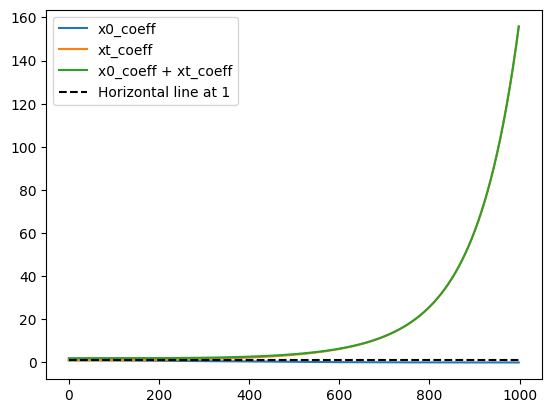

In [ ]:
# prompt: put on the plot all of the x0_coeff, xt_coeff, x0_coeff+xt_coeff, and the horisontal line at 1

import matplotlib.pyplot as plt
plt.plot(x0_coeff, label='x0_coeff')
plt.plot(xt_coeff, label='xt_coeff')
plt.plot(x0_coeff + xt_coeff, label='x0_coeff + xt_coeff')
plt.hlines(1, 0,1000, 'black','--',label='Horizontal line at 1')
plt.legend()
plt.show()


In [ ]:
# !pip install diffusers

from diffusers import DDPMScheduler
scheduler = DDPMScheduler()

# from the diffusers library

alpha_prod_t = scheduler.alphas_cumprod[t]
alpha_prod_t_prev = scheduler.alphas_cumprod[t-1]
beta_prod_t = 1 - alpha_prod_t
beta_prod_t_prev = 1 - alpha_prod_t_prev
current_alpha_t = alpha_prod_t / alpha_prod_t_prev
current_beta_t = 1 - current_alpha_t

pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

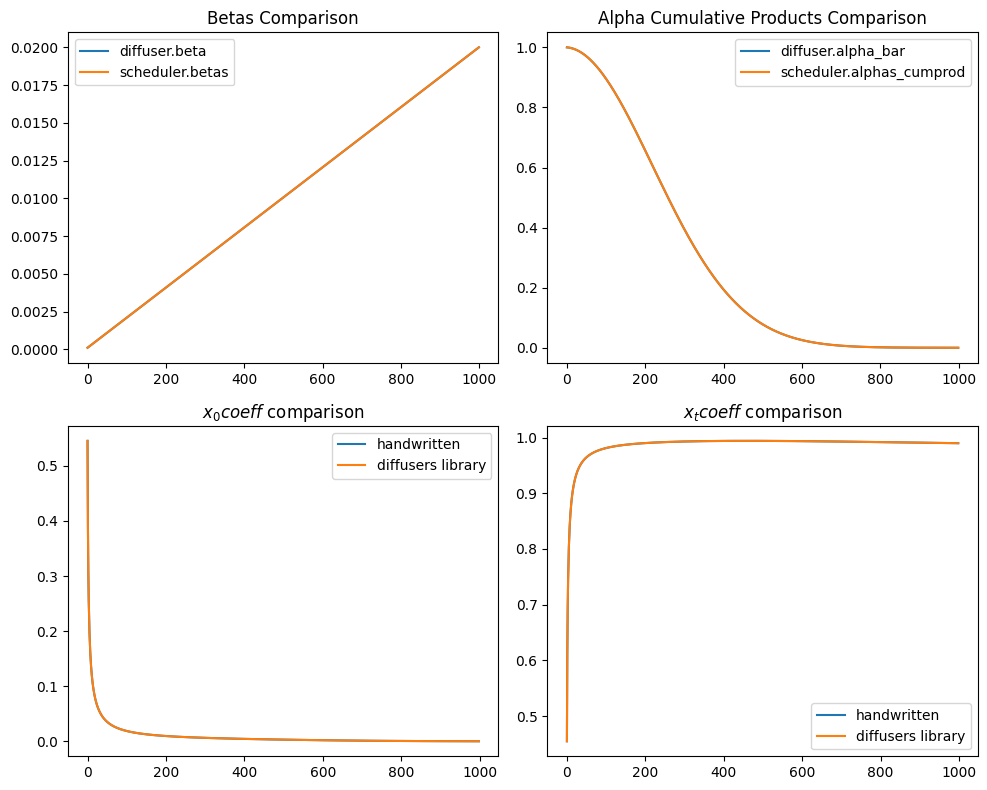

In [ ]:
# prompt: make a figure with 4 graphs that would compare diffuser.beta and scheduler.betas, diffuser.alpha and scheduler.alphas, diffuser.alpha_bar and scheduler.alphas_cumprod, the last graph leave empty

import matplotlib.pyplot as plt

# Assuming 'diffuser' is an instance of BaseDiffuser and 'scheduler' is an instance of DDPMScheduler

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot betas
axs[0, 0].plot(diffuser.beta.cpu(), label='diffuser.beta')
axs[0, 0].plot(scheduler.betas.cpu(), label='scheduler.betas')
axs[0, 0].set_title('Betas Comparison')
axs[0, 0].legend()

# Plot alphas
axs[0, 1].plot(diffuser.alpha_bar.cpu(), label='diffuser.alpha_bar')
axs[0, 1].plot(scheduler.alphas_cumprod.cpu(), label='scheduler.alphas_cumprod')
axs[0, 1].set_title('Alpha Cumulative Products Comparison')
axs[0, 1].legend()

# Plot alpha_bars (cumulative products of alphas)
axs[1, 0].plot(x0_coeff, label='handwritten')
axs[1, 0].plot(pred_original_sample_coeff, label='diffusers library')
axs[1, 0].set_title('$x_0coeff$ comparison')
axs[1, 0].legend()

# Leave the last graph empty
axs[1, 1].plot(xt_coeff, label='handwritten')
axs[1, 1].plot(current_sample_coeff, label='diffusers library')
axs[1, 1].set_title('$x_tcoeff$ comparison')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
current_sample_coeff+pred_original_sample_coeff # from the priginal paper

tensor([0.9999, 1.0001, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

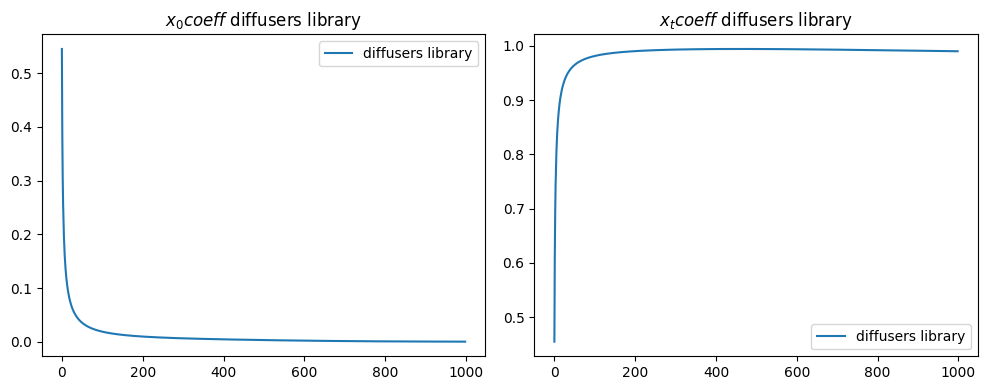

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# axs[0].plot(x0_coeff, label='handwritten')
axs[0].plot(pred_original_sample_coeff, label='diffusers library')
axs[0].set_title('$x_0coeff$ diffusers library')
axs[0].legend()

# axs[1].plot(xt_coeff, label='handwritten')
axs[1].plot(current_sample_coeff, label='diffusers library')
axs[1].set_title('$x_tcoeff$ diffusers library')
axs[1].legend()

plt.tight_layout()
plt.show()


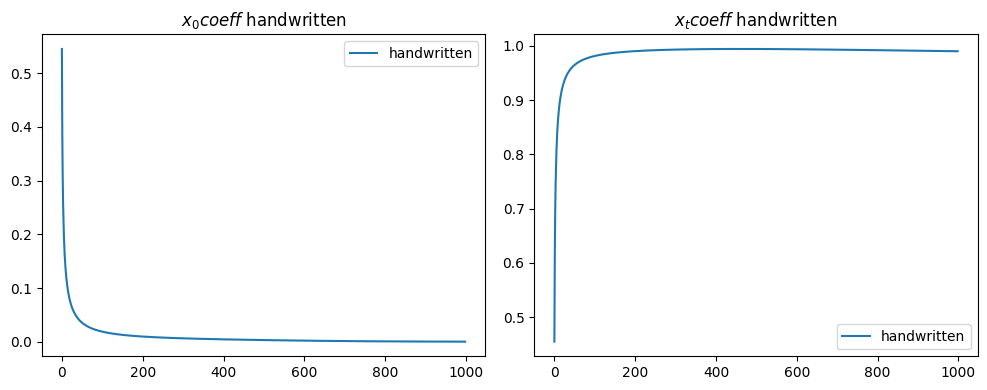

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(x0_coeff, label='handwritten')
# axs[0].plot(pred_original_sample_coeff, label='diffusers library')
axs[0].set_title('$x_0coeff$ handwritten')
axs[0].legend()

axs[1].plot(xt_coeff, label='handwritten')
# axs[1].plot(current_sample_coeff, label='diffusers library')
axs[1].set_title('$x_tcoeff$ handwritten')
axs[1].legend()

plt.tight_layout()
plt.show()

### The general MLP model for the stable diffusion

In [ ]:
# Copied from https://github.com/sattarov/FinDiff/blob/main/MLPSynthesizer.py

import torch
from torch import nn
import math


def init_linear_layer(input_size, hidden_size):
    linear = nn.Linear(input_size, hidden_size, bias=True)
    nn.init.kaiming_normal_(linear.weight)
    nn.init.constant_(linear.bias, 0.0)
    return linear


def timestep_embedding(timesteps, dim_out, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim_out: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim_out // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim_out % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class MLP(nn.Module):
    """ Base FeedForward Network
    """
    def __init__(self, hidden_size, activation='lrelu'):
        super(MLP, self).__init__()
        # init encoder architecture
        self.layers = self.init_layers(hidden_size)
        if activation == 'lrelu':
            self.activation = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        elif activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            print('WRONG bottleneck function name !!!')

    def init_layers(self, layer_dimensions):
        layers = []
        for i in range(len(layer_dimensions)-1):
            linear_layer = init_linear_layer(layer_dimensions[i], layer_dimensions[i + 1])
            layers.append(linear_layer)

            self.add_module('linear_' + str(i), linear_layer)
        return layers

    def forward(self, x):
        # Define the forward pass
        for i in range(len(self.layers)):
            x = self.activation(self.layers[i](x))
        return x


class MLPSynthesizer(nn.Module):
    """ Feed Forward Network used as a synthesizer in the diffusion process."""
    def __init__(
            self,
            d_in: int,
            hidden_layers: list,
            activation: str='lrelu',
            dim_t: int=64,
            n_classes=None
        ):
        """ Constructor for initializing the synthesizer

        Args:
            d_in (int): dimensionality of the input data
            hidden_layers (list): list of the neurons in every hidden layer
            activation (str, optional): activation function. Defaults to 'lrelu'.
            dim_t (int, optional): dimensionality of the intermediate layer for connecting the embeddings. Defaults to 64.
            n_cat_tokens (int, optional): number of total categorical tokens. Defaults to None.
            n_cat_emb (int, optional): dim of categorical embeddings. Defaults to None.
            embedding (tensor, optional): provide if learned embeddings are given. Defaults to None.
            embedding_learned (bool, optional): flag whether the embeddings need to be learned. Defaults to True.
            n_classes (int, optional): total number of classes, if conditional sampling is required. Defaults to None.
        """
        super(MLPSynthesizer, self).__init__()
        self.dim_t = dim_t
        self.mlp = MLP([dim_t, *hidden_layers], activation=activation)

        # embed label
        if n_classes is not None:
            self.label_emb = nn.Embedding(n_classes, dim_t)

        # projection used for the input data
        self.proj = nn.Sequential(
            nn.Linear(d_in, dim_t),
            nn.SiLU(),
            nn.Linear(dim_t, dim_t)
        )

        # projection for the time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t),
            nn.SiLU(),
            nn.Linear(dim_t, dim_t)
        )

        # used for the output layer
        self.head = nn.Linear(hidden_layers[-1], d_in)

    def forward(self, x, timesteps, label=None):

        # time embeddings
        emb = self.time_embed(timestep_embedding(timesteps, self.dim_t))

        # add label embeddings
        if label is not None:
            emb = emb + self.label_emb(label)

        x = self.proj(x) + emb

        # additional mlp layers
        x = self.mlp(x)
        x = self.head(x)
        return x

In [ ]:
model = MLPSynthesizer(d_in=784,
            hidden_layers=[784*2, 784*4, 784*2],
            activation='lrelu',
            dim_t=784,
            n_classes=10)

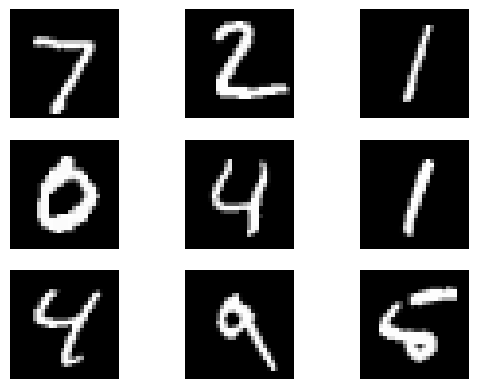

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(x_test[i], cmap='gray')
  plt.axis('off')

plt.show()

### Training the model

In [ ]:
# write a trainloop that would iterate through the train_dataloader, perform timesteps=diffuser.sample_timesteps(64), add noise to the object from x_train having t=timesteps, and do the denoise step

In [ ]:
#@markdown trainloop
# from tqdm import tqdm
# import numpy as np


def train_epoch(
        dataloader,
        synthesizer,
        diffuser,
        loss_fnc,
        optimizer,
        scheduler,
    ):
    """Training module for single epoch, update model parameters and return losses

    Args:
        dataloader (_type_): torch Dataloader
        synthesizer (_type_): model synthesizer
        diffuser (_type_): diffuser model
        loss_fnc (_type_): loss function
        optimizer (_type_): optimizer
        scheduler (_type_): learning rate scheduler

    Returns:
        dict: losses
    """
    total_losses = []

    # iterate over distinct mini-batches
    for batch_x, batch_y in dataloader:
        # set network in training mode
        synthesizer.train()

        # sample timestamps t
        timesteps = diffuser.sample_timesteps(n=batch_x.shape[0])

        # add noise
        batch_noise_t, noise_t = diffuser.add_noise(x_num=batch_x, t=timesteps)

        # conduct forward encoder/decoder pass
        predicted_noise = synthesizer(x=batch_noise_t, timesteps=timesteps, label=batch_y)

        # compute train loss
        train_losses = loss_fnc(
            input=noise_t,
            target=predicted_noise,
        )

        # reset encoder and decoder gradients
        optimizer.zero_grad()

        # run error back-propagation
        train_losses.backward()

        # optimize encoder and decoder parameters
        optimizer.step()

        # collect rec error losses
        total_losses.append(train_losses.detach().cpu().numpy())

    # average of rec errors
    total_losses_mean = np.mean(np.array(total_losses))

    # update learning rate according to the scheduler
    scheduler.step()

    return {'losses': total_losses_mean}

In [ ]:
epochs=10
learning_rate=1e-4
seed=42
batch_size=64

mlp_layers = [784*2, 784*4, 784*2]
activation = 'lrelu'

diffusion_steps = 500
diffusion_beta_start = 1e-4
diffusion_beta_end = 0.02
scheduler = 'linear'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu").type

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
synthesizer_model = MLPSynthesizer(d_in=784,
            hidden_layers=mlp_layers,
            activation=activation,
            dim_t=784,
            n_classes=10).to(device) #.to(torch.float32)
diffuser_model = BaseDiffuser(synthesizer_model,
                              diffusion_steps=diffusion_steps,
                              device=device)

parameters = filter(lambda p: p.requires_grad, synthesizer_model.parameters())
optimizer = optim.Adam(parameters, lr=learning_rate)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
loss_fnc = nn.MSELoss()

In [ ]:
# overall_loss = []
# synthesizer_model = synthesizer_model.to(device)

epochs = 80
pbar = tqdm(iterable=range(epochs), position=0, leave=True)

for epoch in pbar:
    base_params = {'epoch': epoch, 'seed': seed, 'mlp_layers': mlp_layers}
    epoch_loss = []

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.flatten(1).to(device)
        batch_y = batch_y.to(device)

        synthesizer_model.train()

        timesteps = diffuser_model.sample_timesteps(n=batch_x.shape[0])
        batch_noise_t, noise_t = diffuser_model.add_noise(x_num=batch_x, t=timesteps)
        predicted_noise = synthesizer_model(x=batch_noise_t, timesteps=timesteps, label=batch_y)
        loss = loss_fnc(
            input=noise_t,
            target=predicted_noise,
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        epoch_loss.append(loss.detach().cpu().numpy())
    overall_loss.append(np.mean(np.array(epoch_loss)))

    # prepare and set training epoch progress bar update
    # now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    pbar.set_description('epoch: {}, train-loss: {}'.format(str(epoch).zfill(4), str(overall_loss[-1])))

epoch: 0079, train-loss: 0.54093456: 100%|██████████| 80/80 [10:18<00:00,  7.73s/it]


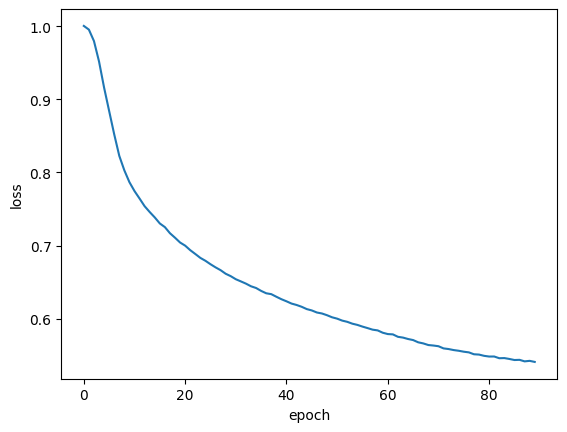

In [ ]:
plt.plot(overall_loss)
plt.xlabel('epoch')
plt.ylabel('loss');

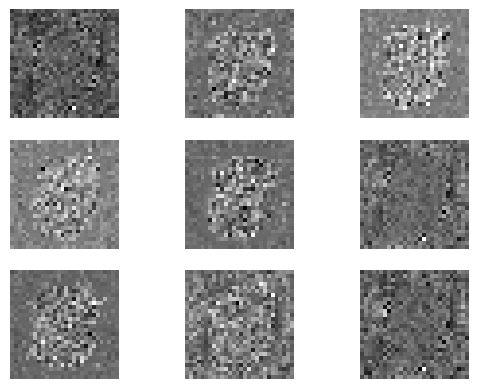

In [ ]:
# Took about 10 mins of training and 100 epochs to get this result


label = torch.arange(1,10).to(device)
sz = (label.shape[0],28**2)
sampled = diffuser_model.sample(sz,label)

for i in range(0,9):
  plt.subplot(3, 3, i+1)
  plt.imshow(sampled[t][i].detach().numpy().reshape(28,28), cmap='gray')
  plt.axis('off')

plt.show()

In [ ]:
# prompt: make an interactive image with a slider so that I could iterate between times t and see the for i in range(0,9):
#   plt.subplot(3, 3, i+1)
#   plt.imshow(sampled[t][i].detach().numpy().reshape(28,28), cmap='gray')
#   plt.axis('off')
# plt.show()

import ipywidgets as widgets
from IPython.display import display

# Assuming 'sampled' is a tensor of shape (diffusion_steps, 9, 28*28)

def display_images(t):
  fig, axs = plt.subplots(3, 3, figsize=(8, 8))
  for i in range(0,9):
    row = i // 3
    col = i % 3
    axs[row, col].imshow(sampled[t][i].detach().cpu().numpy().reshape(28,28), cmap='gray')
    axs[row, col].axis('off')
  plt.show()

# Create a slider to select the timestep
timestep_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=diffusion_steps - 1,
    step=1,
    description='Timestep:',
    continuous_update=False
)

# Display the interactive plot
widgets.interact(display_images, t=timestep_slider)


interactive(children=(IntSlider(value=0, continuous_update=False, description='Timestep:', max=499), Output())…

<function __main__.display_images(t)>

In [ ]:
num_params = sum(p.numel() for p in synthesizer_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 14769776


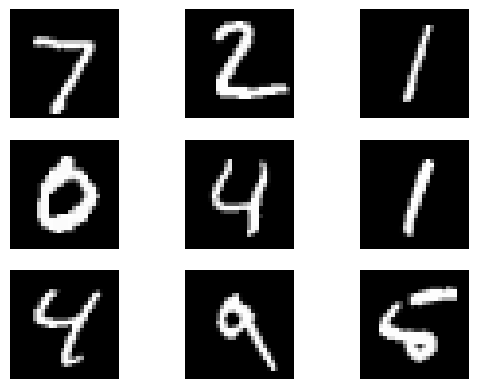

In [ ]:
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(x_test[i], cmap='gray')
  plt.axis('off')

plt.show()

# Let us redefine the model to have less params and see whether it will achieve some quality, or I will need to do sth simpler

### Can also try and import a pretrained UNet to see whether my diffusion part of the model works